# Problem 1

## 1c: decay of continuous P2O map eigenvalues

In [180]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True


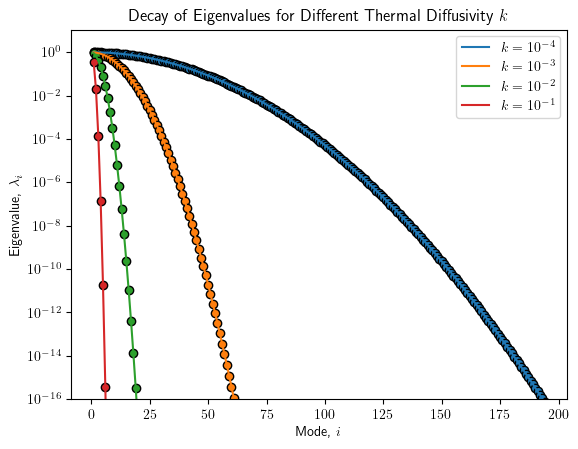

In [181]:
# Constants
T = 1
L = 1

def eigenvalues(k):
    eigvals = []
    i = 1
    eigval = 1  # Arbitrary initial value to start the loop
    while eigval >= 10**(-16):
        eigval = np.exp(-k * T * (i * np.pi / L)**2)  
        eigvals.append(eigval)  # Append to list
        i += 1  # Increment index
    return eigvals

# Loop through k values and plot eigenvalues
for k in np.logspace(-4, -1, 4):  # Added range for logspace
    eigvals = eigenvalues(k)
    plt.plot(range(1, len(eigvals) + 1), eigvals, "-", label=rf"$k=10^{{{int(np.log10(k))}}}$")
    plt.scatter(range(1, len(eigvals) + 1), eigvals, marker = "o", edgecolors="black")

    
# Configure plot
plt.yscale('log')  # Log scale for y-axis
plt.ylim(10**(-16))
plt.xlabel(r"Mode, $i$")
plt.ylabel(r"Eigenvalue, $\lambda_{i}$")
plt.title("Decay of Eigenvalues for Different Thermal Diffusivity $k$")
plt.legend()
plt.show()

When using $ T = 1$ and $ L = 1 $ for the heat diffusion problem, the eigenvalues of the continuous operator $ F $ decay exponentially. We know the eigenvalues, $\lambda_{i} = e^{-kT(i\pi/L)^{2}} $, decay exponentially with respect to the squared mode, $i^{2}$ (decay is proportional to the negative quadratic term, which grows rapidly); this is shown by the quadratic relation between the eigenvalues and the modes on a logarithmic scale. 

For higher thermal diffusivities, the eigenvalues decay more quickly (with respect to the modes). With higher thermal diffusivities, the initial heat distribution $m(x)$ is rapidly dispersed; when measurement/observation data is collected at the same final time $T$, more information about the initial heat distribution has been lost for large thermal diffusivities (data for the heat distribution $d(x,T) \approx 0$), leading to less accurate inverse problem solutions (recovering $m(x)$). The continuous operator $F$ becomes more ill-posed for larger $k$ as the eigenvalues approach machine precision faster. 

For small thermal diffusivities, the rate of eigenvalue decay is lower for higher modes; at time $T$, more modes are recoverable (more eigenvalues of higher frequency) meaning more detail/information of the initial heat distribution is preserved. 

## 1d: decay of discretized P2O map eigenvalues

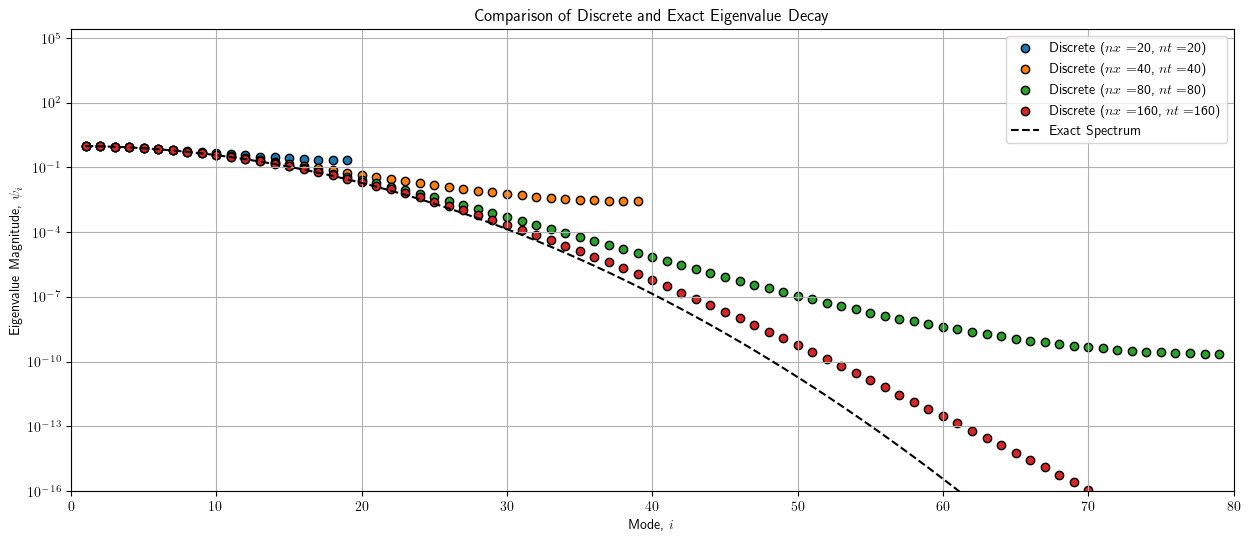

In [182]:
import numpy as np
import matplotlib.pyplot as plt


# Constants
L = 1       # Length of the domain
k = 0.01    # Diffusion coefficient
T = 0.1     # Final time

def exact_eigenvalues(nx):
    """Compute exact eigenvalues."""
    return [np.exp(-k * T * (i * np.pi / L)**2) for i in range(1, nx)]

def discrete_eigenvalues(nx, nt):
    """Compute discrete eigenvalues."""
    h = L / nx
    delta_t = T / nt
    mu = lambda i: k * 4 / h**2 * np.sin(np.pi * i / (2 * nx))**2
    return [(1 + delta_t * mu(i))**-nt for i in range(1, nx)]

# Discretization pairs (nx, nt)
discretizations = [(20, 20), (40, 40), (80, 80), (160, 160)]

# Plot
plt.figure(figsize=(15, 6))
for nx, nt in discretizations:
    exact = exact_eigenvalues(nx)
    discrete = discrete_eigenvalues(nx, nt)
    plt.scatter(range(1, nx), discrete, label=f"Discrete ($nx=${nx}, $nt=${nt})", marker='o', edgecolors="black")
    if nx == 160:  # Plot exact for the finest resolution
        plt.plot(range(1, nx), exact, label="Exact Spectrum", linestyle="--", color="black")

# Configure plot
plt.yscale('log')
plt.ylim(10**(-16))
plt.xlim(0,80)
plt.xlabel("Mode, $i$")
plt.ylabel("Eigenvalue Magnitude, $\psi_i$")
plt.title("Comparison of Discrete and Exact Eigenvalue Decay")
plt.legend()
plt.grid()
plt.show()


For higher resolution (finer temporal and spatial discretization), the discrete operator's eigenvalues, $\psi_{i}$, match the continuous operator's eigenvalues, $\lambda_{i}$, more accurately, especially for higher modes. 

For the plotted discretizations above, the discretized operator's eigenvalues are always larger than the true/continuous operator's eigenvalues. Additionally, the true eigenvalues decay more rapidly than the discretized eigenvalues. With these two facts, we can conclude that discretization of the operator results in regularization of the problem. Coarse discretizations provide more regularization than finer discretizations; for 20 spatial/temporal elements, the recoverable eigenvalues are on the same scale of magnitude, while, for 160 spatial/temporal elements, the recoverable eigenvalues drop more than 16 orders of magnitude. Coarse discretizations elimate higher modes (and smaller eigenvalues), and slightly increase the magnitude for the remaining low mode eigenvalues; combined, these two effects make the inverse problem less ill-posed (acting as a regularizer) for coarser discretizations (but also lead to less accurate forward problem solutions).


To recheck the discretized operator's eigenvalues, we can also plot the numerically evaluated eigenvalues (via the eigensolver written in the provided Notebook01_Ill_posedness.ipynb):


/tmp/ipykernel_31144/719482091.py:53: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = la.spsolve(A, u_old)


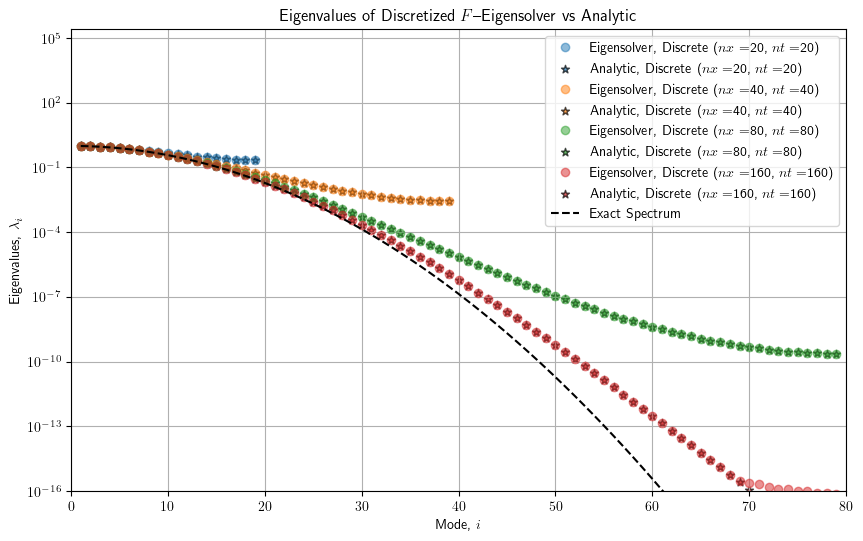

In [183]:
import scipy.sparse as sp
import scipy.sparse.linalg as la
def assembleMatrix(k, h, dt, n):
    """
    The function assembles the matrix (I + \delta_t K)
    Here:
    - k is the thermal diffusivity coefficient
    - h is the spacial discretization size
    - dt is the temporal discretization size
    - n is the number of subintervals
    """
    # To assemble matrix K, first create 3 diagonals
    # and then call scipy function `spdiags`,
    # which creates a sparse matrix given the diagonals
    diagonals = np.zeros((3, n))   # 3 diagonals
    diagonals[0,:] = -1.0/h**2
    diagonals[1,:] =  2.0/h**2
    diagonals[2,:] = -1.0/h**2
    K = k*sp.spdiags(diagonals, [-1,0,1], n,n)
    
    # M holds an identity matrix,
    # which is assembled similarly to K,
    # but by specifying only main diagonal of ones
    M = sp.spdiags(np.ones(n), 0, n,n)
    
    return M + dt*K
    
def solveFwd(m, k, h, dt, n, nt):
    """
    The function computes the temperature at the final time, u(T),
    for a given initial condition m.
    Here:
    - m is the initial condition
    - k is the thermal diffusivity coefficient
    - h is the spacial discretization size
    - dt is the temporal discretization size
    - n is the number of subintervals 
    - nt is the number of time steps
    """
    
    
    # Assemble the matrix (note, that it is
    # constant, so we can use it for all time steps)
    A = assembleMatrix(k, h, dt, n)
    
    # u_old holds the most recent known value of u
    u_old = m.copy()
    
    # solve the system for nt time steps
    for i in np.arange(nt):
        # scipy function `spsolve` solves 
        # sparse linear system
        u = la.spsolve(A, u_old)
        u_old[:] = u
        
    return u        
def computeEigendecomposition(k, n, nt):
    h = L/float(nx)
    dt = T/float(nt)
    ## Compute F as a dense matrix
    F = np.zeros((n,n))
    m_i = np.zeros(n)
    
    for i in np.arange(n):
        m_i[i] = 1.0
        F[:,i] = solveFwd(m_i, k, h, dt, n, nt)
        m_i[i] = 0.0
    
    ## solve the eigenvalue problem
    lmbda, U = np.linalg.eigh(F)
    ## sort eigenpairs in decreasing order
    lmbda[:] = lmbda[::-1]
    lmbda[lmbda < 0.] = 0.0
    U[:] = U[:,::-1]
    
    return lmbda, U 


plt.figure(figsize=(10, 6))
for nx, nt in discretizations:
    lmbda, U = computeEigendecomposition(k, nx-1, nt)
    # plt.figure(figsize=(20,10))
    plt.semilogy(range(1, len(lmbda)+1),lmbda, 'o', label=f"Eigensolver, Discrete ($nx=${nx}, $nt=${nt})", alpha = .5)
    discrete = discrete_eigenvalues(nx, nt)
    plt.scatter(range(1, nx), discrete, label=f"Analytic, Discrete ($nx=${nx}, $nt=${nt})",marker='*', edgecolors="black", alpha = .7)
    if nx == 160:  # Plot exact for the finest resolution
        exact = exact_eigenvalues(nx)
        plt.plot(range(1, nx), exact, label="Exact Spectrum", linestyle="--", color="black")
plt.legend()  
plt.xlabel(r"Mode, $i$")
plt.ylabel(r"Eigenvalues, $\lambda_{i}$")
plt.title("Eigenvalues of Discretized $F$--Eigensolver vs Analytic")
plt.yscale('log')
plt.ylim(10**(-16))
plt.xlim(0,80)
plt.grid()
plt.show()


Per the above plot, we see that the analytic eigenvalues and the eigensolver-derived eigenvalues match, generally. Eigensolver-derived eigenvalues with magnitude near machine precision--$10^{-16}$--do not match with the analytic eigenvalues exactly, which is as expected; near machine precision, error is acceptable in the eigensolvers. With the above plot, we can confirm that the analytic/derived eigenvalues are accurate.


# Problem 2

## 2b: comparision of eigenvalues of discrete vs continuous P2O operator

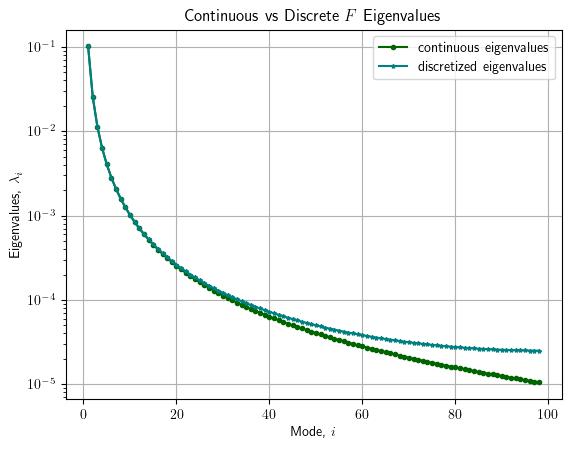

In [184]:
k = 1
l = 1
nx = 100
h = l / nx
L = l 
i = np.arange(1, nx-1)
discrete = h**2 / (4 * k * (np.sin(np.pi * i / (2 * nx)))**2) 
continuous = L**2 / (i**2 * np.pi**2 * k)
plt.title(r"Continuous vs Discrete $F$ Eigenvalues")
plt.plot(i,continuous, label = "continuous eigenvalues", color = "darkgreen", marker = "o", markersize = 3)
plt.plot(i,discrete, label = "discretized eigenvalues",color = "teal", marker = "*", markersize = 3)
plt.yscale('log')
plt.xlabel(r"Mode, $i$")
plt.ylabel(r"Eigenvalues, $\lambda_{i}$")
plt.legend()
plt.grid()
plt.show()


For small modes (large eigenvalues), the continuous and discrete $F$ eigenvalues match. As the mode increases, however, and the eigenvalues decrease, the discrete $F$ eigenvalues gain more error from the continuous $F$ eigenvalues. As further explained/shown in problem 1d, discretization acts similarly to a regularizer, boosting/increasing small eigenvalues. 

## 2c: poisson inverse problem without regularization

In [185]:
import scipy.sparse as sp
import scipy.sparse.linalg as la

# SMALL_SIZE = 20
# MEDIUM_SIZE = 30
# BIGGER_SIZE = 40
# plt.rc('font', size=SMALL_SIZE)          
# plt.rc('axes', titlesize=SMALL_SIZE)     
# plt.rc('axes', labelsize=SMALL_SIZE)    
# plt.rc('xtick', labelsize=SMALL_SIZE)    
# plt.rc('ytick', labelsize=SMALL_SIZE)    
# plt.rc('legend', fontsize=SMALL_SIZE)    
# plt.rc('figure', titlesize=BIGGER_SIZE)  

def plot(f, style, **kwargs):
    x = np.linspace(0., L, nx+1)
    f_plot = np.zeros_like(x)
    f_plot[1:-1] = f
    plt.plot(x,f_plot, style, **kwargs)

def assemblePoissonMatrix(h, n, k):
    diagonals = np.zeros((3, n))   # 3 diagonals for Laplacian
    diagonals[0,:] = -1.0/h**2
    diagonals[1,:] =  2.0/h**2
    diagonals[2,:] = -1.0/h**2
    A = sp.spdiags(diagonals, [-1,0,1], n, n)
    return A * k

def solvePoisson(f, h, n, k):
    A = assemblePoissonMatrix(h, n, k)
    u = la.spsolve(A, f)
    return u

def plot_datagen(m_source, m_inverted, u_true, u_forward, d,noise,nx,k):
    # Plot results
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plot(m_source, "-.", color = "indigo", label = r'true $m(x)$')
    plot(m_inverted, "*", color = "cornflowerblue", label = r'inverted $m(x)$' )
    plt.legend(loc = "upper left")
    plt.title(r"Source term $m(x)$")
    plt.xlabel(r"$x$, Location along bar")
    plt.ylabel(r"$\|m(x)\|$")

    plt.subplot(1,3,2)
    plot(u_true, ".-", color = "indigo", label = r"$u(x)$")
    plot(d, "*", markersize = 7, color = "cornflowerblue", label = r"$d(x)$, data")
    plt.legend(loc = "upper left")
    plt.title(r"Solution $u(x)$ vs Data $d(x)$")
    plt.xlabel(r"$x$, Location along bar")
    plt.ylabel(r"$\|u(x)\|$")

    plt.subplot(1,3,3)
    plot(u_true, ".-", color = "indigo", label = r'$u(x)$')
    plot(u_forward, "*", color = "mediumblue", label = r'$u(x)$ forward prediction')
    plot(d, "o",color = "mediumaquamarine", markersize = 2, label = r"$d(x)$, data")
    plt.legend(loc = "upper left")
    plt.title(r"Solution $u(x)$, $d(x)$, and forward prediction")
    plt.xlabel(r"$x$, Location along bar")
    plt.ylabel(r"$\|u(x)\|$")
    
    plt.suptitle(rf"$\sigma = {noise:.1e},\ n_x = {nx},\ k = {k}$")
    plt.show()

In [186]:
import matplotlib.cm as cm 
def assembleF(k, h, n):
    F = np.zeros((n,n))
    m_i = np.zeros(n)
    
    for i in np.arange(n):
        m_i[i] = 1.0
        F[:,i] = solvePoisson(m_i, h, n, k)
        m_i[i] = 0.0
    return F

def solveTikhonov(d, F, alpha):    
    H = np.dot( F.transpose(), F) + alpha*np.identity(F.shape[1])
    rhs = np.dot( F.transpose(), d)
    return np.linalg.solve(H, rhs)



# Physical parameters for Poisson problem
m_true = lambda x: np.maximum( np.zeros_like(x), 1. - np.abs(1. - 4.*x)) + 100.*np.power(x,10)*np.power(1.-x,2)

# Discretization (default)
L = 1.0
k = 1.0 
nx = 100  
noise = 10**(-4)
h = L / float(nx)
x = np.linspace(0.+h, L-h, nx-1)

def calcu_m(noise_std_dev, nx, k):
    
    h = L / float(nx)
    x = np.linspace(0.+h, L-h, nx-1)
    F = assembleF(k, h, nx-1)
    m_source = m_true(x)
    u_true = solvePoisson(m_source, h, nx-1, k)
    d = u_true + noise_std_dev*np.random.randn(u_true.shape[0])
    m_inverted = solveTikhonov(d, F, alpha=0) # no regularization, naive inversion 
    u_forward =  solvePoisson(m_inverted, h, nx-1, k)
    return m_source, m_inverted, u_true, u_forward, d

The first set of graphs considers the variation in data (standard deviation of noise addition is $\sigma$). Next, we consider the effects of varying rod elastic modulus $k$ on the inverse problem. Finally, we we consider the effects of discretization ($n_{x}$) on inversion. 

Column 1 shows the source term $m(x)$ and the inverted source term (solution of the inverse problem). Column 2 shows the known displacement (forward prediction of true $m(x)$) $u(x)$ and the data $d(x)$ formed by adding error to $u(x)$. Column 3 shows the difference between the true displacement $u(x)$, the forward prediction of the inverted source term, and the data used for inversion $d(x)$. 

### variation in $\sigma$

/tmp/ipykernel_31144/1978269560.py:31: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = la.spsolve(A, f)


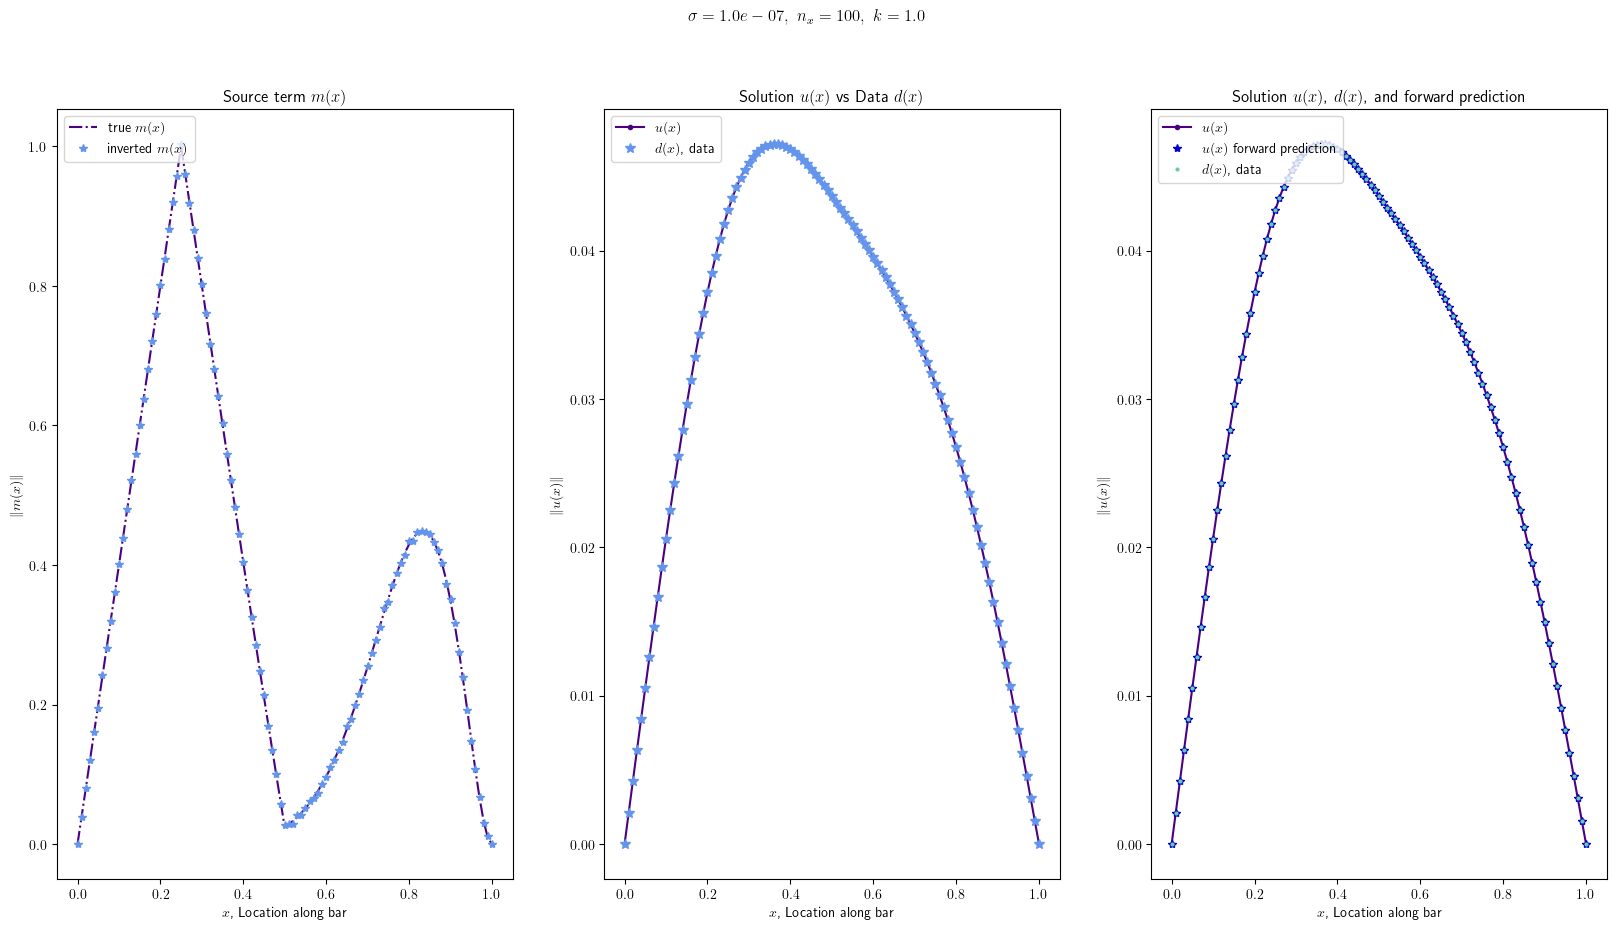

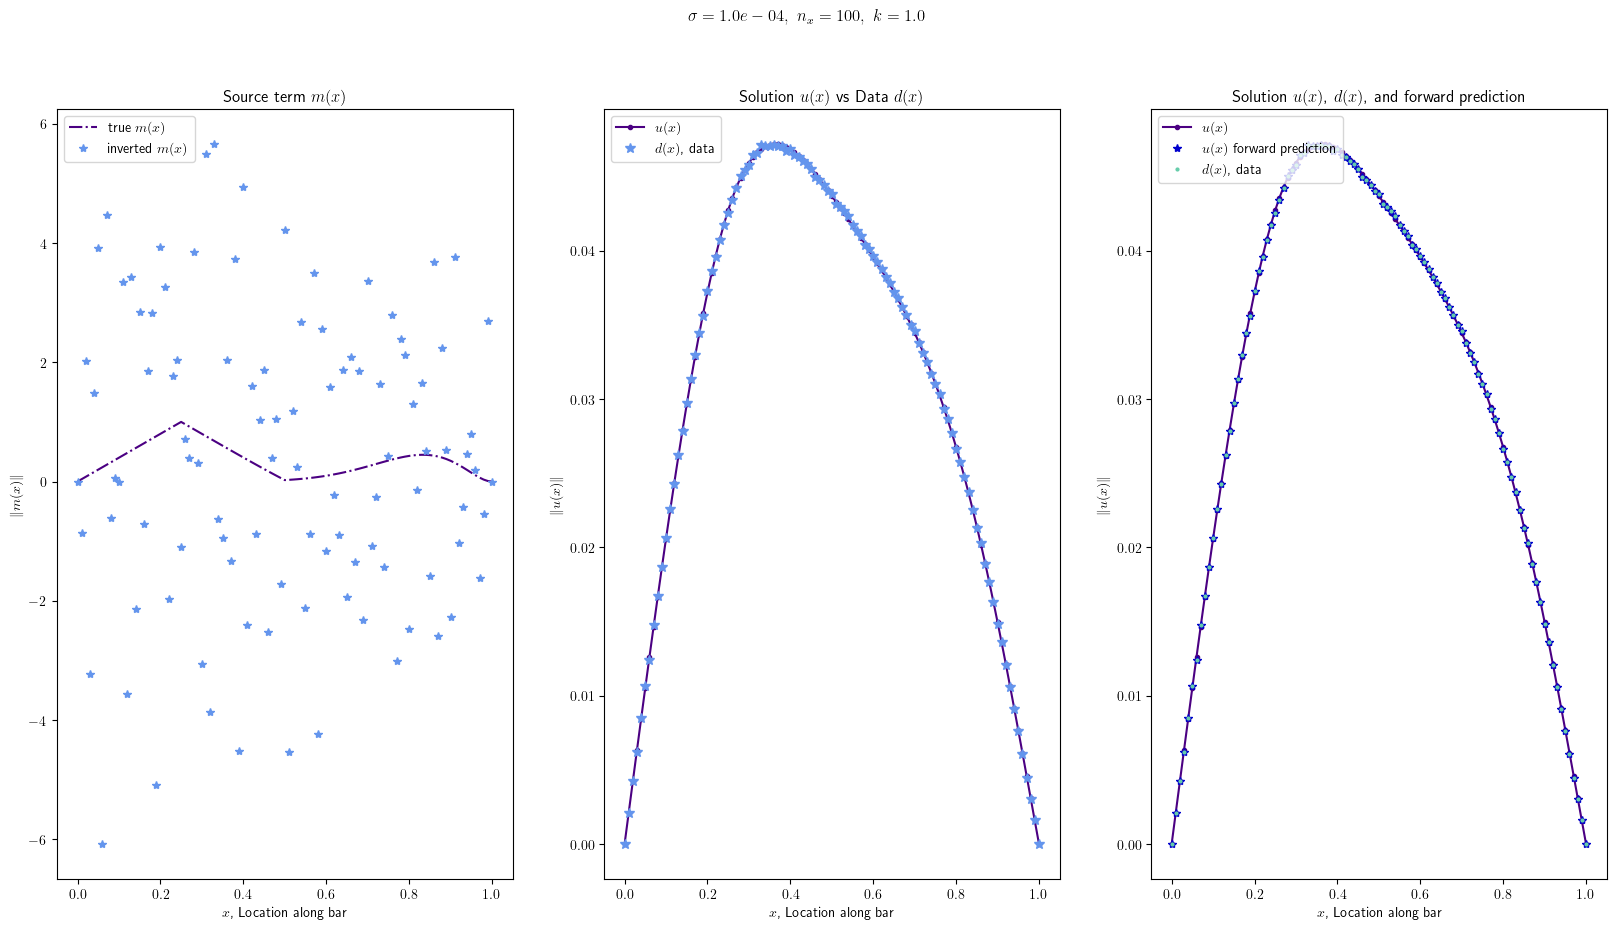

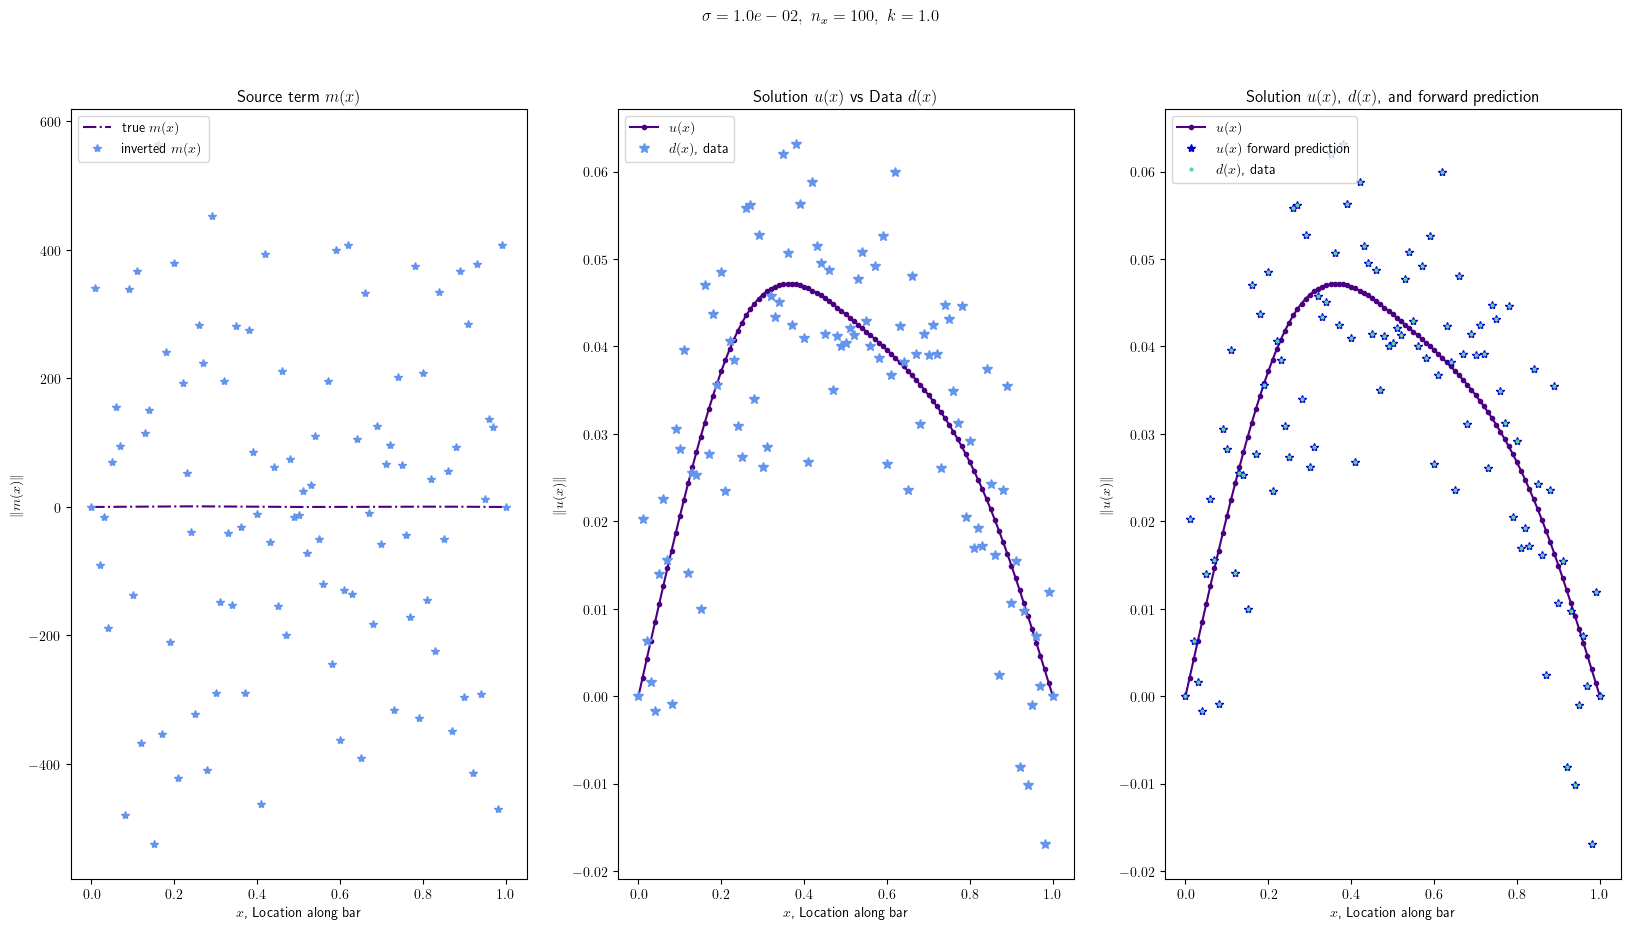

In [187]:
noises = [10**(-7), 10**(-4), 10**(-2)]
for noise in noises:
    plot_datagen(*calcu_m(noise,nx,k),noise,nx,k)

As expected, increases in the noise of data $d(x)$ cause increases in the error of inverted $m(x)$. We notice that for large $\sigma$, the inverted $m(x)$ is quite unstable (large magnitudes $\|m(x)\|$). However, despite the large noise, the predicted displacement (based on inverted $m(x)$) matches the data field $d(x)$ quite well, suggesting that the error in $m(x)$ is due to the data error ($\sigma$) (model overfits to error) rather than inherent model/physics/computational error. 

### variation in $k$

/tmp/ipykernel_31144/1978269560.py:31: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = la.spsolve(A, f)


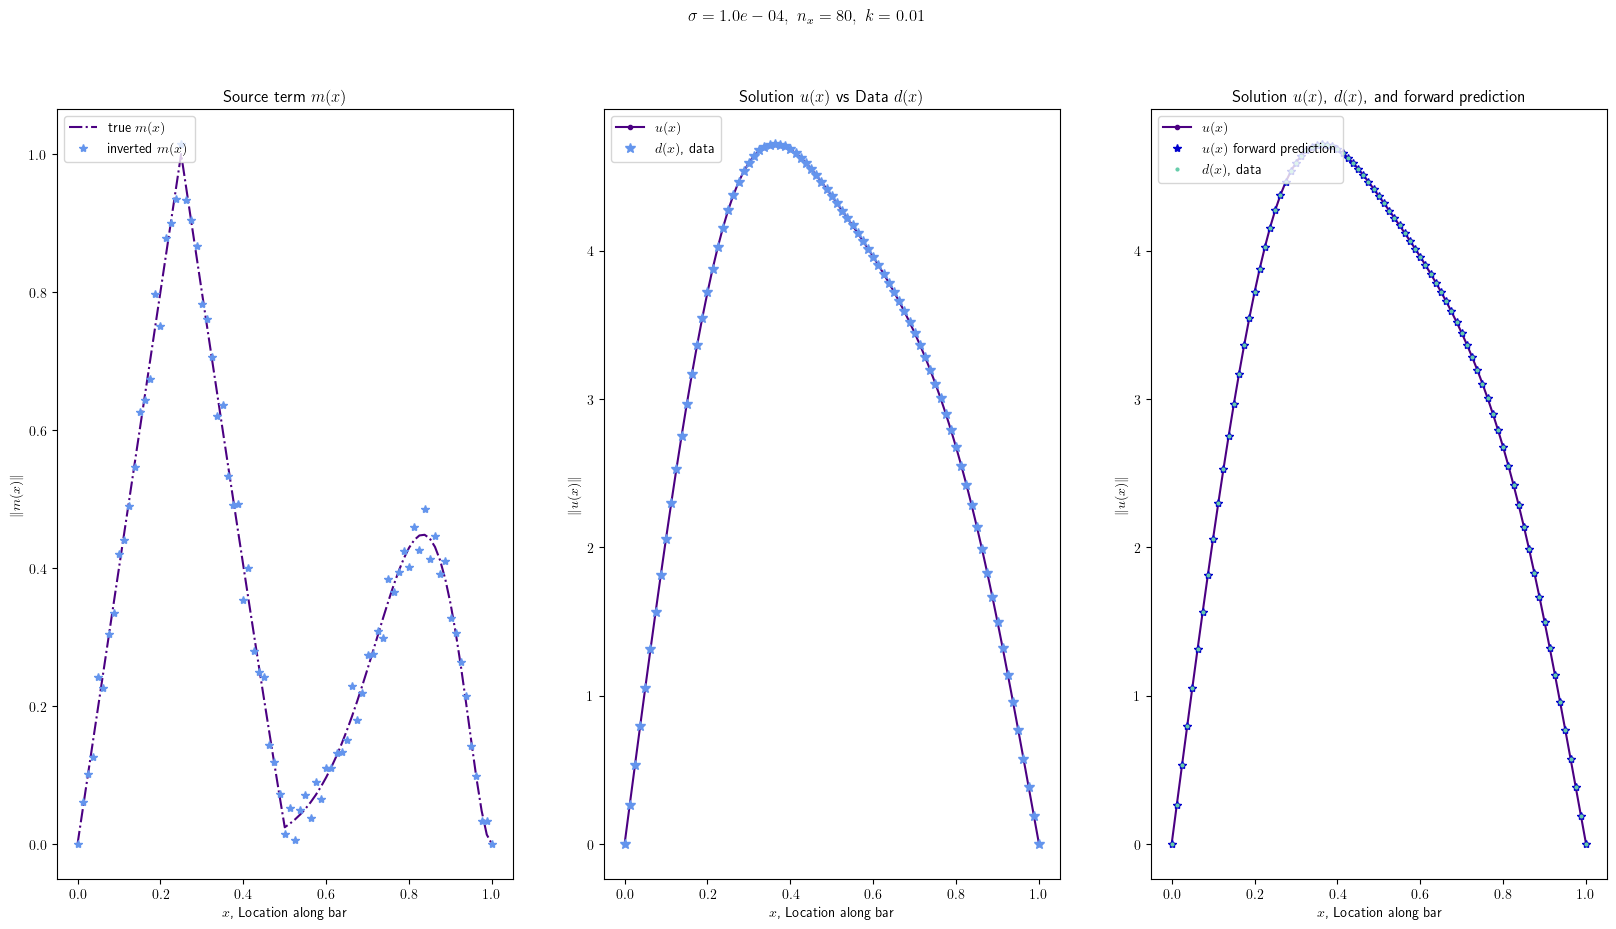

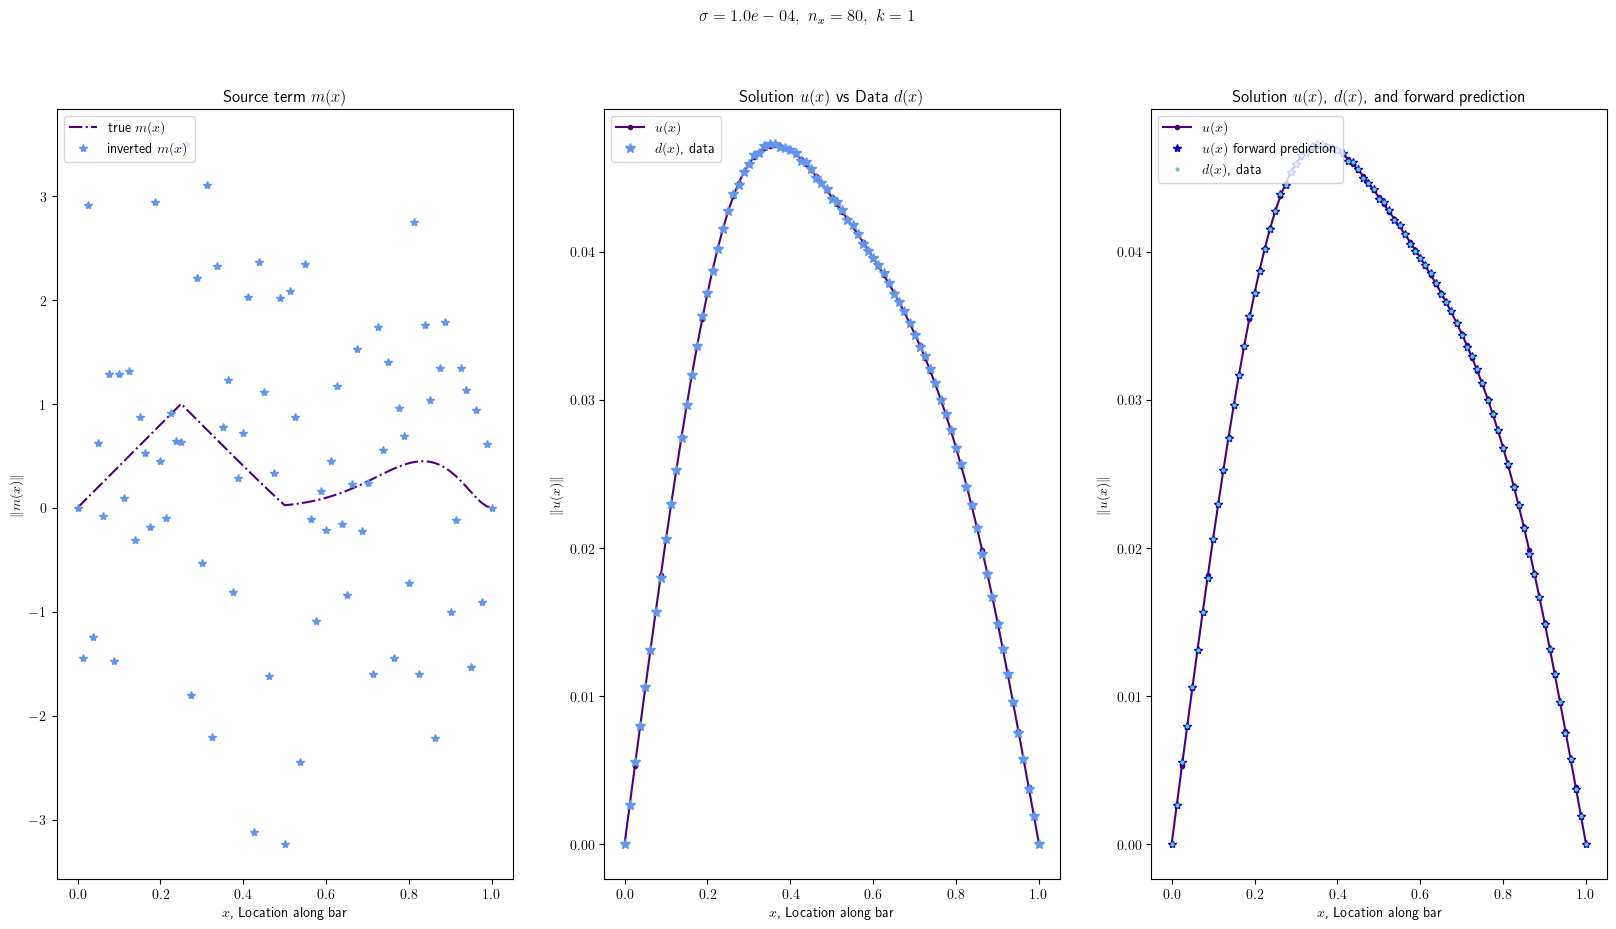

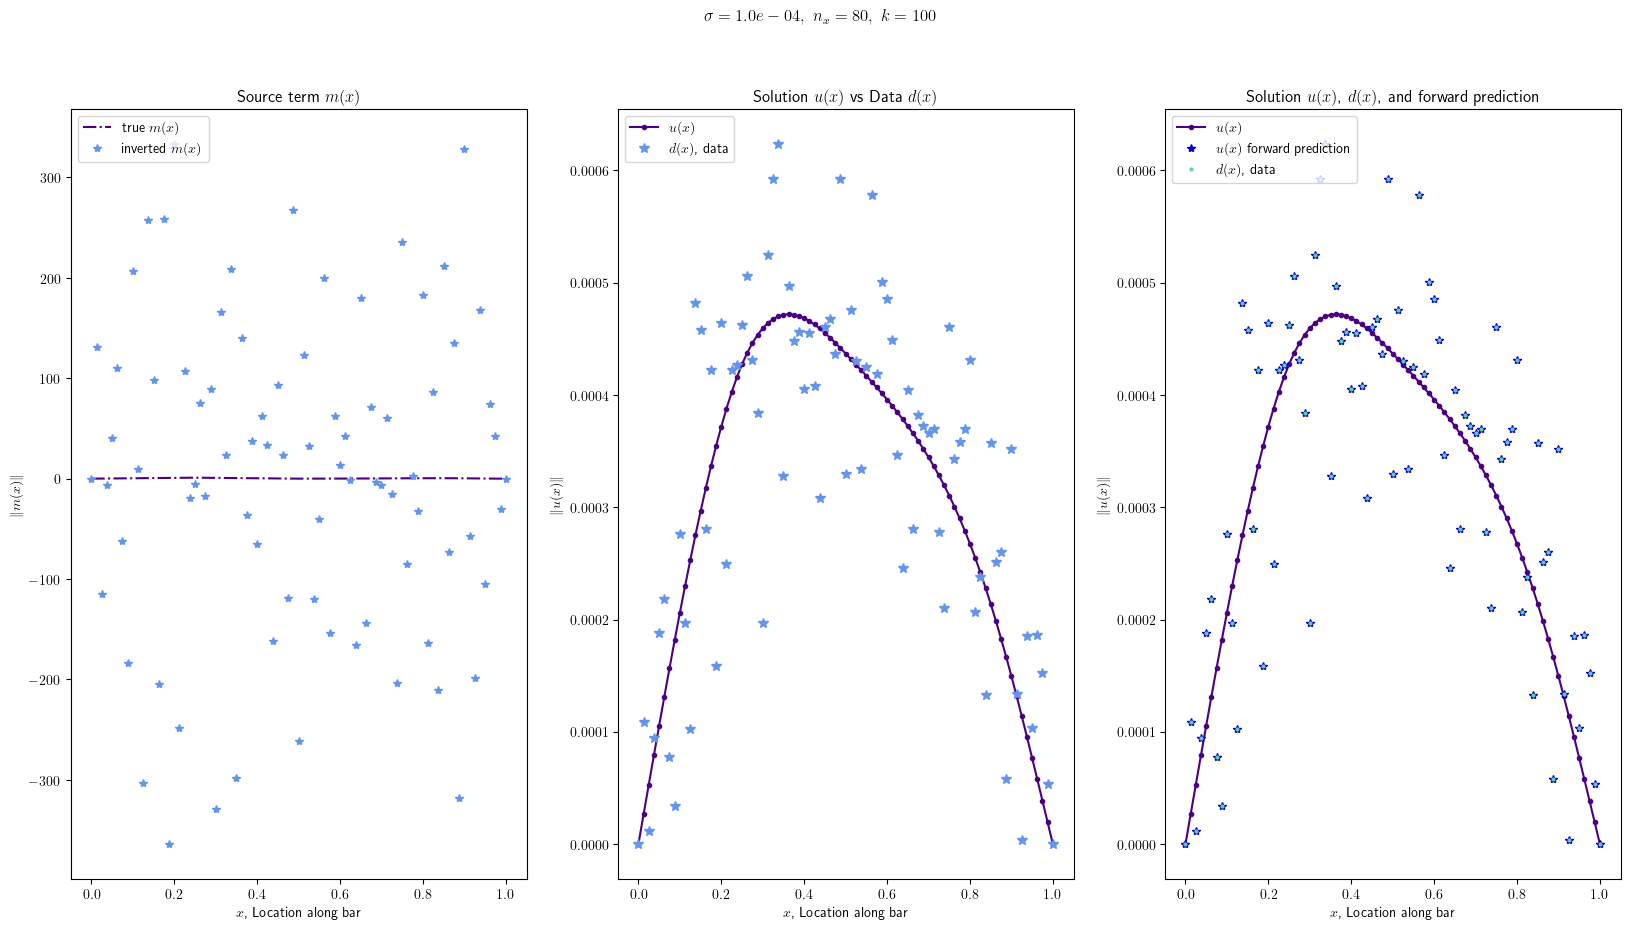

In [228]:
noise = 10**(-4) # reset to default
nx = 80
ks = [10**(-2), 1, 10**(2)]
for k in ks:
    plot_datagen(*calcu_m(noise,nx,k),noise,nx,k)

Increased stiffness $k$ under non-zero standard deviation of noise $\sigma$ leads to increased noise in the inverted $m(x)$. Notice the relative noise of the data is also increased; increased stiffness leads to overall reduced magnitude of displacement ($\|u(x)\|$) but $\sigma$ is constant. For small measurements of displacement, any error in measurement becomes highly obvious (signal to noise ratio is reduced). With more faulty/erraneous data, inversion for $m(x)$ becomes unstable. Additionally, since the eigenvalues of the P2O map, $F$, are proportional to $k^{-1}$, for increases in $k$, the eigenvalues are reduced, further contributing to the instability of of the inverse problem. 

The predicted displacements and the noisy observed data still match fairly well, suggesting that the model is again overfitting to the noise of the data, as in the above example.

### variation in discretization $n_x$

/tmp/ipykernel_31144/1978269560.py:31: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = la.spsolve(A, f)


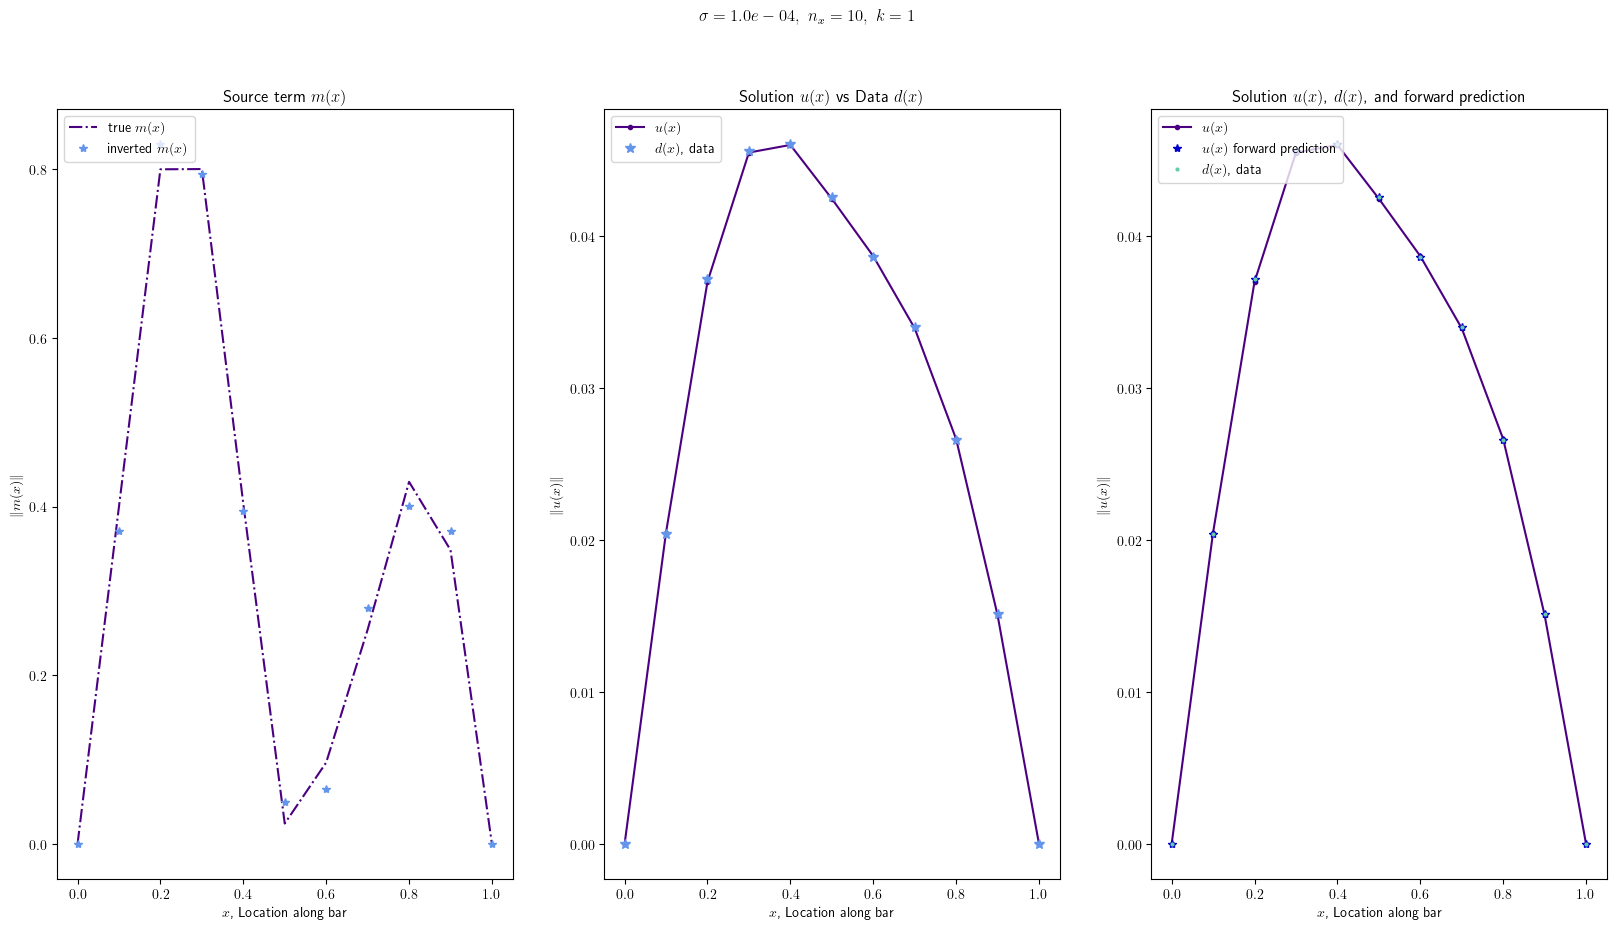

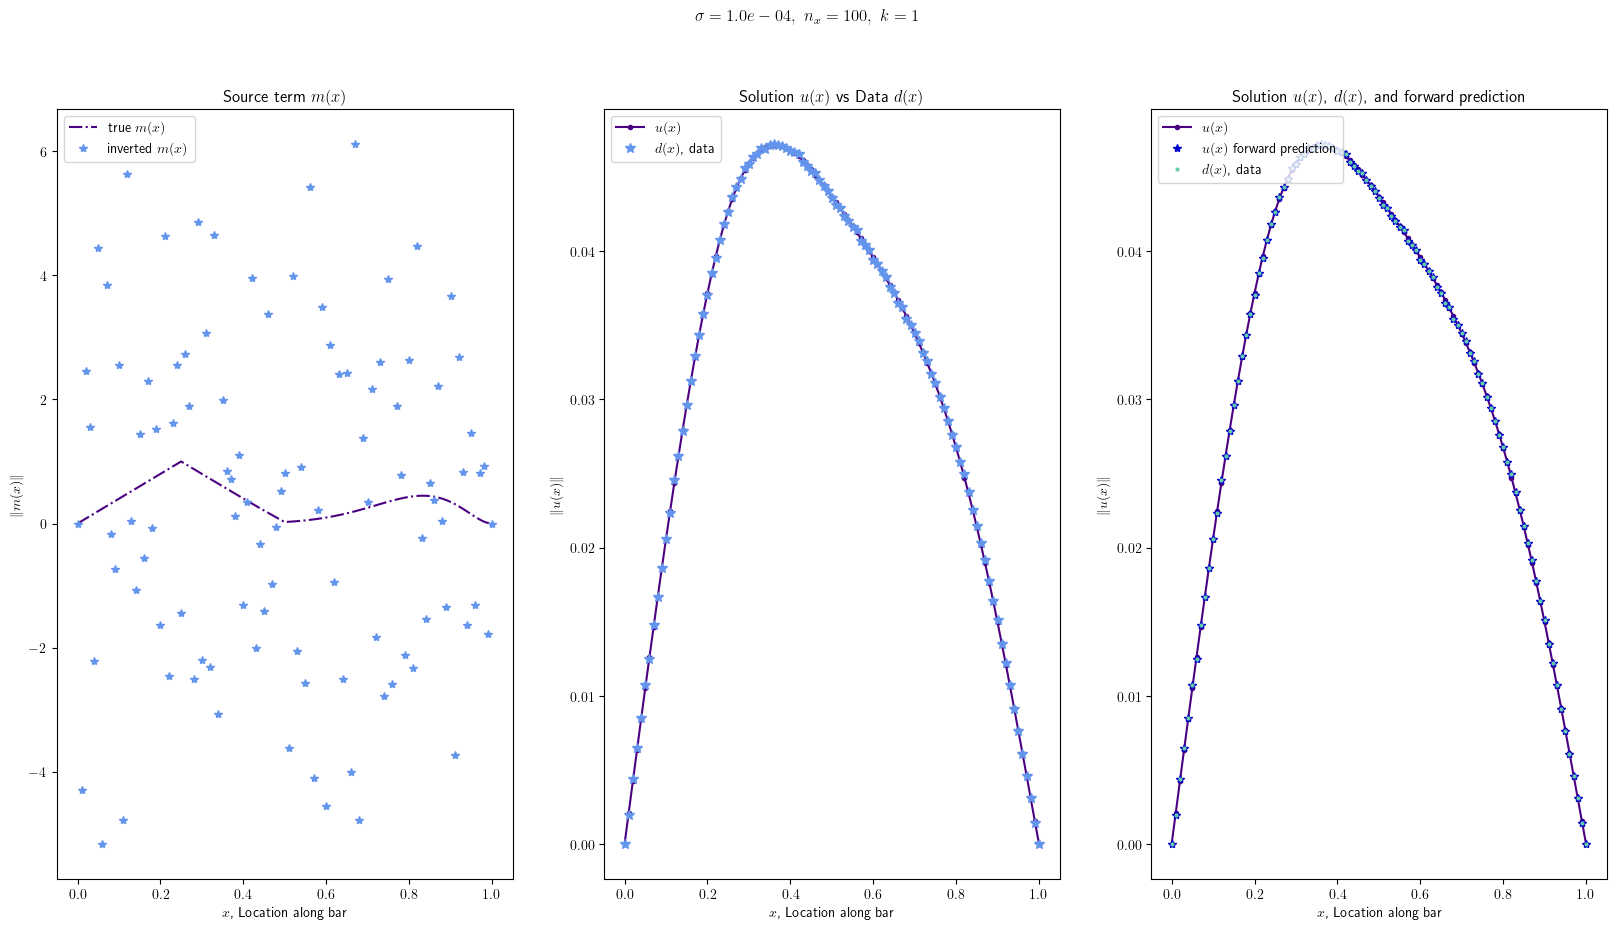

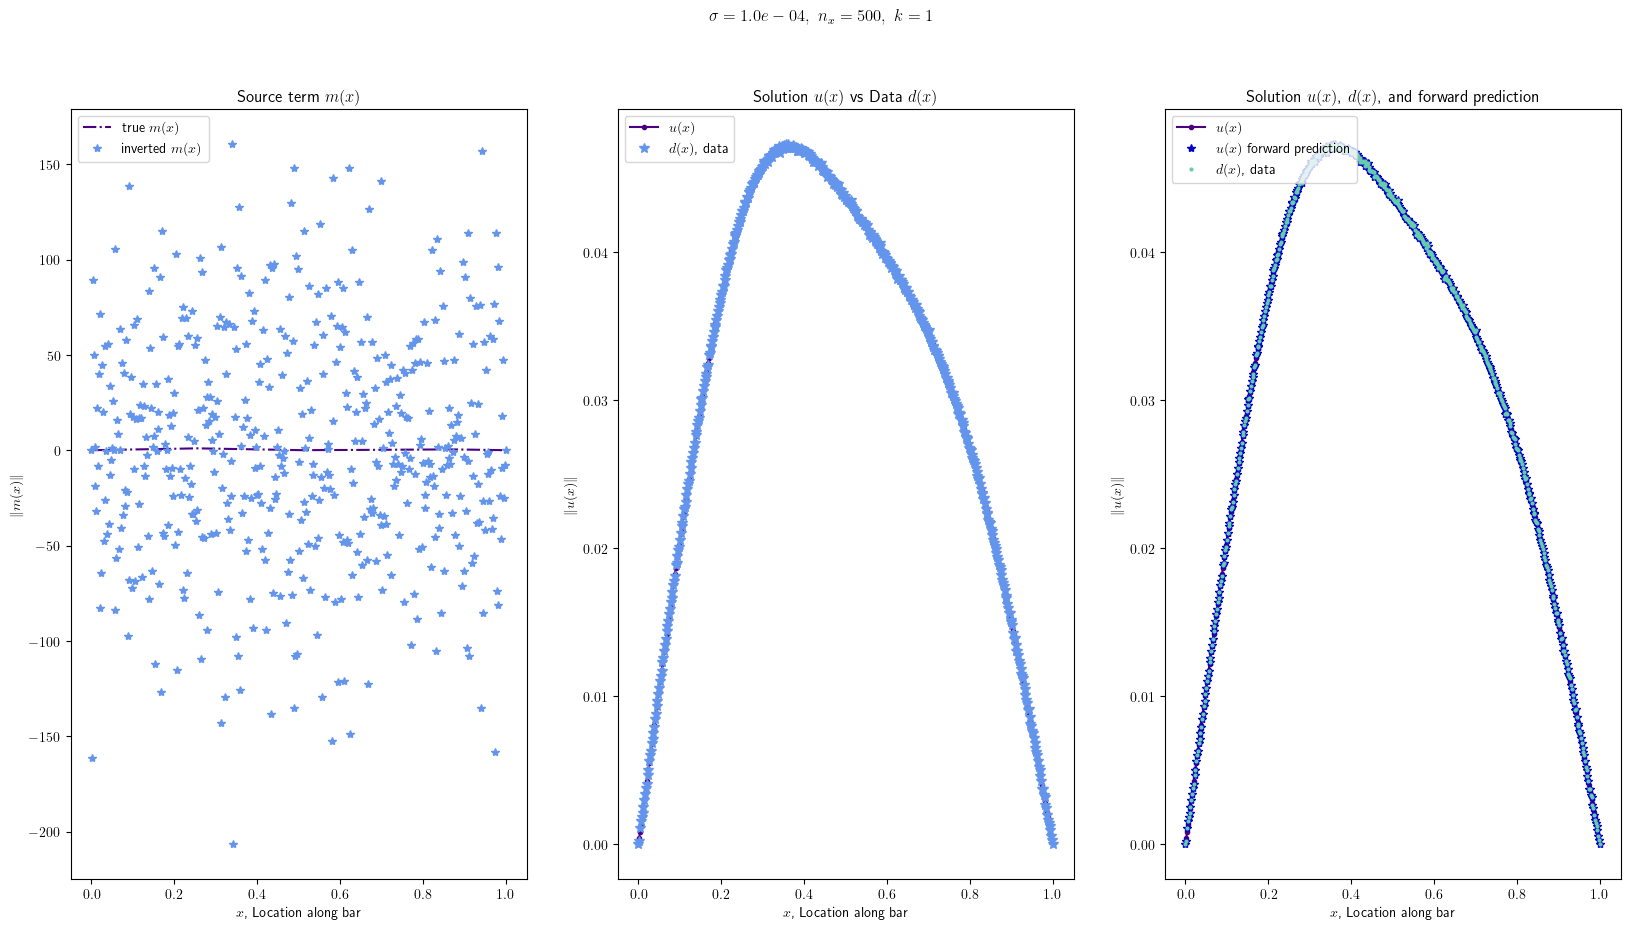

In [232]:
k = 1 # reset to default
nxs = [10, 100, 500]
for nx in nxs:
    plot_datagen(*calcu_m(noise,nx,k),noise,nx,k)

Inversion for $m(x)$ is most accurate at coarse discretizations ($n_{x} = 10$ is more accurate than $n_{x} = 100, 500$). As suggested in problem 1, coarse discretization acts similar to a regularizer. 

Notice that the discrete eigenvalues decay as the mode increases from 1 to $n_{x}-1$ : $\lambda_i \propto \frac{1}{\sin^2 \left(\frac{\pi i}{2 n_x} \right)}$ for $i = 1, 2, ....n_{x}-1$. 

For small $n_{x}$, the smallest eigenvalue ($i = n_{x}-1$), is relatively large (>1), but for larger $n_{x}$, the smallest eigenvalue ($i = n_{x}-1$) is much smaller and approaches 1 (although 1 is not a small eigenvalue, consider that the eigenvalue is also proportional to $h^{2}$). Inversion error is caused by small eigenvalues (error is proportional to inverse of the eigenvalue), so coarse discretizations with large eigenvalues correspond to less ill-posedness. Additionally, for coarser meshes, there is reduced alignment between the high mode eigenvectors (not stored/considered) and the error associated with gaussian noise (white noise has high modes). 

The condition number of the discretized Poisson matrix (P2O map) also increases, meaning that the inverse problem becomes more ill-conditioned. For larger systems, round-off errors can also increase (especially when dealing with small eigenvalues), ultimately leading to instable $m(x)$ inversion. 

Note that the predicted displacements (per inverted $m(x)$) and the noisy observed data still match fairly well for both the coarse and fine discretizations. This suggests while the inverse problem might be highly ill-conditioned, the forward problem is well-posed.  

## 2d:  Tikhanov regularized solution ("eyeball" norm)

/tmp/ipykernel_31144/1978269560.py:31: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = la.spsolve(A, f)


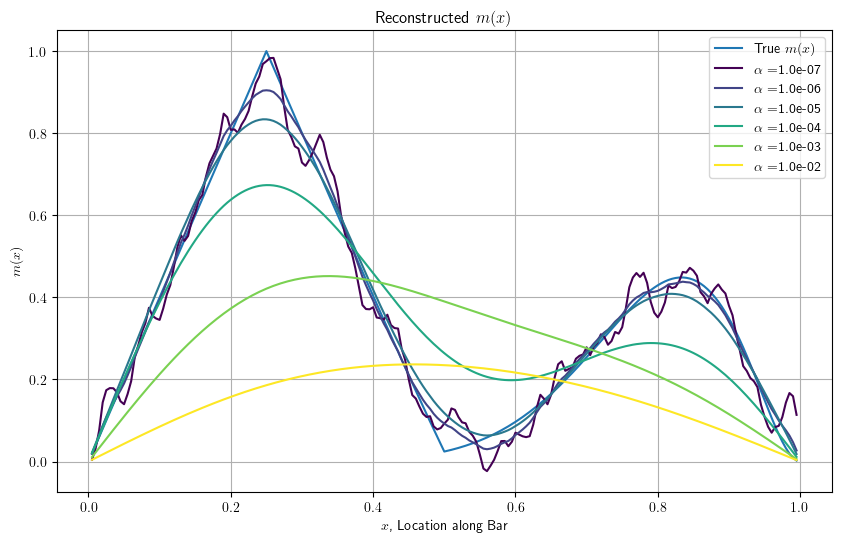

In [190]:
# reset all to standard parameters + nx = 200
k = 1
noise = 10**(-4)
nx = 200

h = L / float(nx)
x = np.linspace(0.+h, L-h, nx-1)
F = assembleF(k, h, nx-1)
u_true = solvePoisson(m_true(x), h, nx-1, k)
d = u_true + noise*np.random.randn(u_true.shape[0])

# Plotting
plt.figure(figsize=(10, 6))
cmap = plt.colormaps.get_cmap('viridis')
plt.plot(x, m_true(x), "-", label= r"True $m(x)$")

alphas = np.logspace(-7,-2,6)
for i, alpha in enumerate(alphas):
    m_alpha = solveTikhonov(d, F, alpha) 
    plt.plot(x, m_alpha, "-", color=cmap(i / (len(alphas) - 1)), label= r'$\alpha = $' + f"{alpha:.1e}")


plt.legend(loc = "upper right")
plt.title(r"Reconstructed $m(x)$")
plt.ylabel(r"$m(x)$")
plt.xlabel(r"$x$, Location along Bar")
plt.grid()
plt.show()

Visually, we expect the ideal regularization $\alpha$ to be between $10^{-6}$ and $10^{-7}$, possibly closer to $10^{-6}$.

## 2e: L-curve for $\alpha$ optimization

/tmp/ipykernel_31144/1978269560.py:31: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = la.spsolve(A, f)


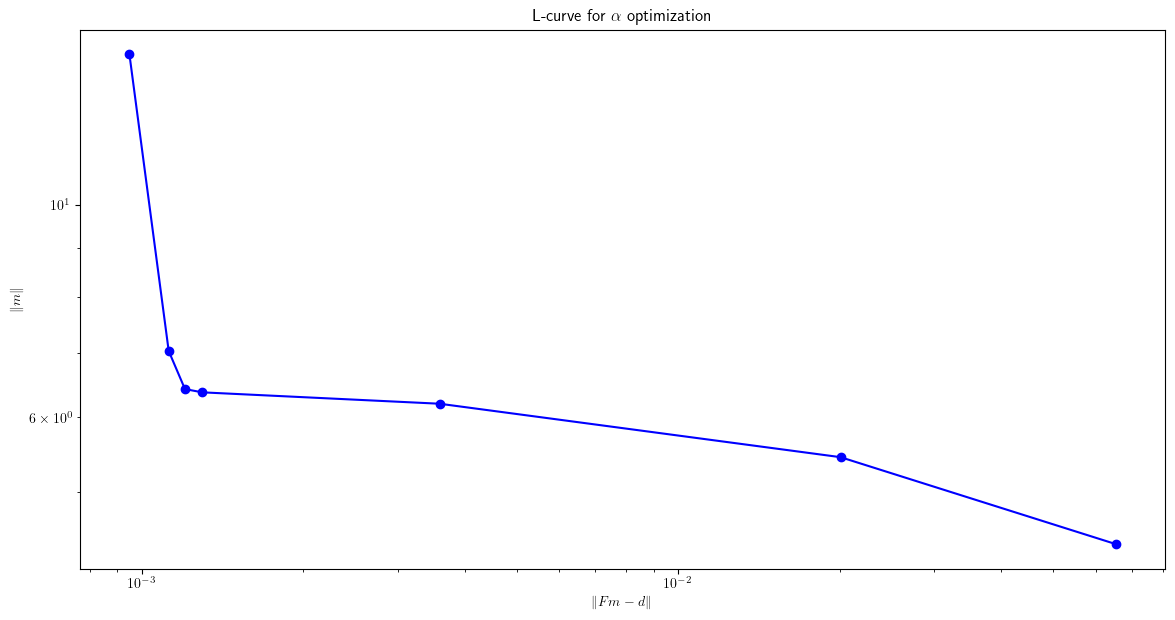

In [203]:
norm_m = [] #norm of parameter
norm_r = [] #norm of misfit (residual)
plt.figure(figsize=(14,7))
for alpha in [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]:
    m_alpha = solveTikhonov(d, F, alpha)
    norm_m.append( np.sqrt( np.dot(m_alpha,m_alpha) ) )
    u_alpha = solvePoisson(m_alpha, h, nx-1, k)
    norm_r.append( np.sqrt( np.dot(d-u_alpha,d-u_alpha) ) )

plt.loglog(norm_r, norm_m, "-ob")
plt.xlabel(r"$\|Fm - d\|$")
plt.ylabel(r"$\| m \|$")
plt.title(r"L-curve for $\alpha$ optimization")
plt.show()

Per the L-curve, $\alpha \approx 10^{-7}$ is the most optimal.

## 2f: Morozov discrepency for $\alpha$ optimization

/tmp/ipykernel_31144/1978269560.py:31: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = la.spsolve(A, f)


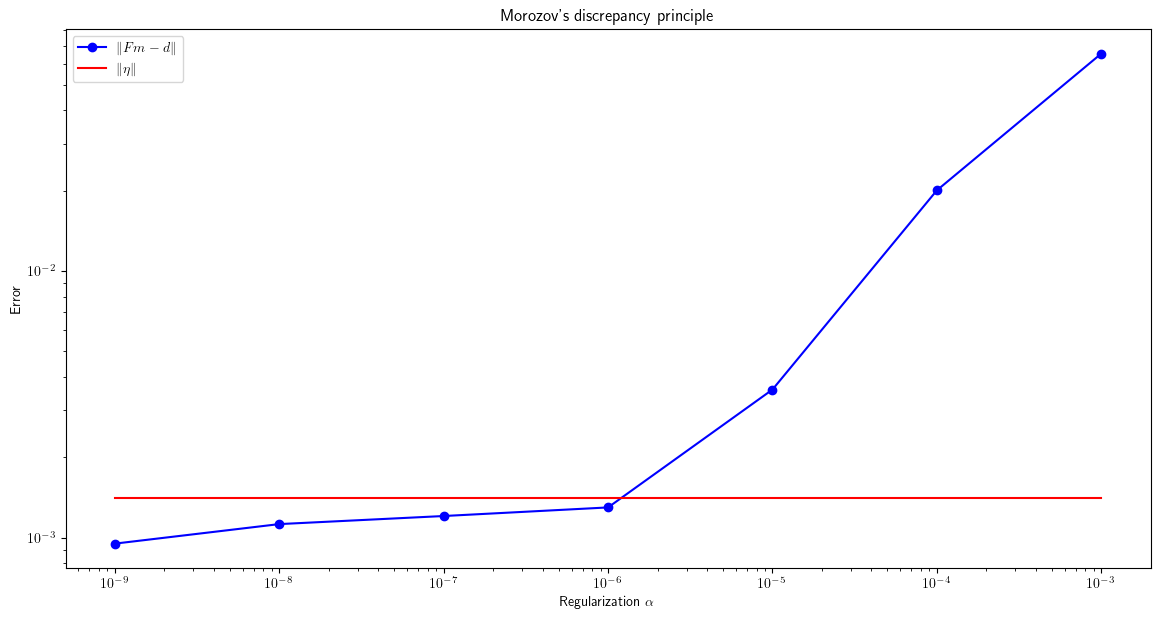

In [219]:
alphas = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
norm_r = [] #norm of misfit (residual)
plt.figure(figsize=(14,7))
for alpha in alphas:
    m_alpha = solveTikhonov(d, F, alpha)
    u_alpha = solvePoisson(m_alpha, h, nx-1, k)
    norm_r.append( np.sqrt( np.dot(d-u_alpha,d-u_alpha) ) )

plt.loglog(alphas, norm_r, "-ob", label=r"$\|Fm - d\|$")
plt.loglog(alphas, [noise*np.sqrt(nx-1)]*len(alphas), "-r", label=r"$\|\eta \|$")
plt.xlabel(r"Regularization $\alpha$")
plt.ylabel("Error")
plt.legend()
plt.title("Morozov's discrepancy principle")
plt.show()

Per the Morozov discrepancy, $\alpha \approx 10^{-6}$ is the most optimal.

## 2g: L2 Norm reconstruction to decide $\alpha$

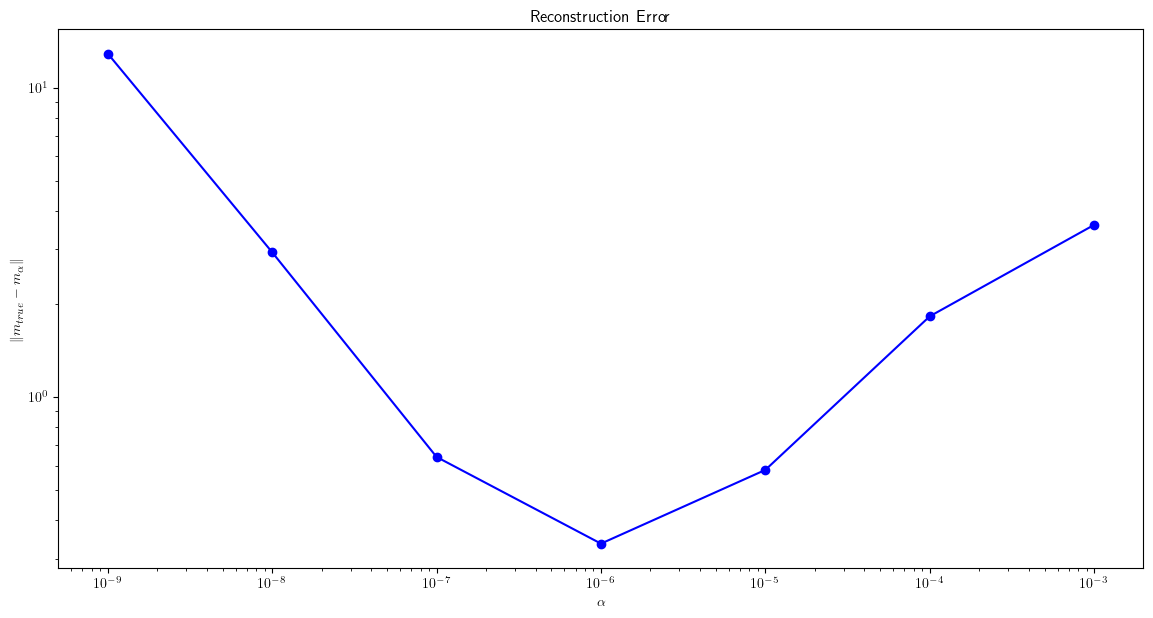

In [225]:
err_m = [] #norm of misfit (residual)
true_m = m_true(x)
plt.figure(figsize=(14,7))
for alpha in alphas:
    m_alpha = solveTikhonov(d, F, alpha)
    err_m.append( np.sqrt( np.dot(true_m-m_alpha,true_m-m_alpha) ) )
    
plt.loglog(alphas, err_m, "-ob")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\|m_{true} - m_{\alpha}\|$")
plt.title("Reconstruction Error")
plt.show()

Per the L2 norm error in the reconstruction, $\|m_{true} − m_{\alpha}\|$, $\alpha \approx 10^{-6}$ is the most optimal.

The regularizers are summarized as: $\alpha_{eyeball} \approx 10^{-6}$, $\alpha_{L-curve} \approx 10^{-7}$, $\alpha_{Morozov} \approx 10^{-6}$, and $\alpha_{L2} \approx 10^{-6}$.

The most optimal value is $\alpha_{Morozov}$ as it considers the data's error when choosing the regularization magnitude. Any model error $\|Fm -d\|$ within the data error $\|\eta\|$ should be allowable (no need to reduce regularization). Unlike the "eyeball approximation" or L-curve method, both of which are heurestical, the Morozov method provides the most intuitive $\alpha$ which considers all information (specifically, the error of the data) and has explicit statistical justification. Since we know $\|\eta\|$, the Morozov method is most appropriate.

All methods--eyeball, L-curve, Morozov, and L2 reconstruction--are mostly in accordance ($\alpha \approx 10^{-6}$). The L-curve method is the only method that suggests a slightly different $\alpha \approx 10^{-6}$, but this can be easily explained since: 1) only few $\alpha$ choices are plotting so the curvature could very easily be maximized at $10^{-7}$ rather than $10^{-6}$, 2) the log-log scale makes curvature approximations difficult to observe, especially with limited points on the L-curve. Note that the L-curve method balances parameter ($m$) stability versus model fidelty while the Morozov method is more concerned with the inherent data error $\|\eta\|$ and the model fidelty (indirectly seeks to stabilize $m$ by choosing maximum regularization). 


# Problem 3

## 3a: eigenvalues, eigenfunctions of continuous P2O map

We derive that the eigenvalue, eigenfunction pair is: $(\lambda_{i}, \nu_{i}) = (\cos(\frac{cT\pi}{L} i), \sqrt{\frac{2}{L}} \sin(\frac{\pi}{L} ix))$, for $ i = 1, 2, ...$

Issues with ill-posedness and stability arise when the eigenvalues $\lambda_{i}$ approach or equal 0. As proved in lecture, the inverse problem error is defined as $m_{true}-m = \sum_{i=1}^{n} \frac{1}{\lambda_{i}} (\nu_{i}^{T} \eta) \nu_{i}$, where $\eta$ is the error in the observable data and $\lambda_{i},\nu_{i}$ are the eigenvalue, eigenvector pair. Small eigenvalues, $\lambda_{i}$, contribute inversely to the error (lead to large errors) and lead to instability.

We notice that the cosine function may achieve 0 for different non-zero final times, $T$, or wave speeds, $c$: we desire $\frac{cT\pi}{L} i \neq n \frac{\pi} {2}$ for $ n = 1, 3, 5 ...$, any positive integer mode $ i = 1, 2, 3 ...$, and any final time $T$ or length $L$. 

This can be achieved by setting the observation time: $T = L/c$. Then,  $\lambda_{i} = \cos(i\pi) = (-1)^{i} \neq 0 \forall { i } \in Z^{+}$; with this setting, the eigenvalues are strictly non-zero, are all on the same order of magnitude (in fact the same magnitude exactly), and do not approach small numbers near machine precision (which leads to large magnification of any data or model noise)! We should now be able to recover the initial condition $m(x)$ perfectly with no instability whatsoever. 


## 3b: ability to reconstruct $m(x)$ for different observation times

Some sources of error that might limit our ability to reconstruct $m(x)$ include:
1. Instrumental error, where the instruments can only capture data to a certain degree of accuracy (e.g. $10^{-3}$ error for a gauge) can cause ill-posedness in the inverse problem. Given most gauges have random noise--white noise with high modes, small eigenvalues--this can dramatically increase error (which is directly proportional to the inverse of the eigenvalue magnitude). Additionally, $d(x,T)$ is observed at a finite number of discrete points along the vable/wire, rather than continuosly over $[0,L]$. 

2. Limited spatial resolution can make the problem underdetermined and ill-posed. Insufficient sampling (and/or poorly distributed sampling) causes higher modes of m(x) to not be caputured accurately; to recognize/reproduce a high mode wave, a large number of data points is required to identify all the crests/troughes of the wave and intermediate curves (especially in comparision to a lower mode wave). 

3. Observation time choices can also affect reconstruction ability. Certain observation times (e.g. $T=\frac{L}{2c}$) cause particular eigenfunctions indistinguishable (further described in 3b) and certain modes to be entirely lost. Without additional measurements, reconstruction of $m(x)$ would be highly innacurate with $\approx$ half the modes missing from $m(x)$ (if limited to observing only $u(x,T)$ at $T=\frac{L}{2c}$).

4. Model error: our model may not account for the entire physics/laws governing the problem. For example, there are specific material or environmental properties like creep, friction, thermal inconsistencies (uneven heating dissipates energy non-uniformly) or air resistance that introduce sources of error unaccounted for in a simple wave model. These sources for error are irreversible and cause excessive damping on some or all modes of data; with data unrepresentative of the initial conditions, the models cannot account for unobserved modes, and thus, will be unable to fully reconstruct $m(x)$.
